# Gender Classification and Eyes Localization

In this example, we are going to implement a multi-task problem. We try to identify the gender of the people, as well as locating their eyes in the images. Hence, we have two different tasks: classification (to identify the gender) and regression (to find the location of the eyes). We are going to use a single network (A CNN) to perform both tasks, however, we will need to apply different loss functions, each proper to a specific task. 

In [ ]:
%pip install poutyne    # to install the putyne library


Let’s import all the needed packages.

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
import zipfile
import cv2
from natsort import natsorted
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, StepLR
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid


## Training Constants

In [ ]:
num_epochs = 3
learning_rate = 0.01
batch_size = 32
image_size = 224
valid_split_percent = 0.1
momentum = 0.5
set_seeds(42)
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the ImageNet dataset for normalizing 
imagenet_std = [0.229, 0.224, 0.225]  # std of the ImageNet dataset for normalizing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The running processor is...', device) 

The running processor is... cuda


## CelebA Dataset

We are going to use CelebA dataset for this experiment. The CelebA 
dataset  is a large-scale face attributes dataset which can be employed as the training and test sets for the following computer vision tasks: face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis.

## Fetching data 


The section below consists of a few lines of codes that help us download celebA dataset from a public web source and unzip them.

In [ ]:
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'

# URL for the CelebA dataset (aligned images, attributes, landmasrks)
url = 'https://graal.ift.ulaval.ca/public/celeba/img_align_celeba.zip'
attr_url = 'https://graal.ift.ulaval.ca/public/celeba/list_attr_celeba.txt'
land_mark_url = 'https://graal.ift.ulaval.ca/public/celeba/list_landmarks_align_celeba.txt'

# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'
land_mark_path = f'{data_root}/list_landmarks_align_celeba.txt'
attr_path = f'{data_root}/list_attr_celeba.txt'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from the source
gdown.download(url, download_path, quiet=False)
gdown.download(land_mark_url, land_mark_path, quiet=False)
gdown.download(attr_url, attr_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://graal.ift.ulaval.ca/public/celeba/img_align_celeba.zip
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:11<00:00, 122MB/s]
Downloading...
From: https://graal.ift.ulaval.ca/public/celeba/list_landmarks_align_celeba.txt
To: /content/data/celeba/list_landmarks_align_celeba.txt
100%|██████████| 12.2M/12.2M [00:00<00:00, 60.4MB/s]
Downloading...
From: https://graal.ift.ulaval.ca/public/celeba/list_attr_celeba.txt
To: /content/data/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 36.4MB/s]


## Create a custom Dataset class

As we are going to implement a multi-task problem by a single CNN, we should provide the CNN with the ground truth in a proper way. Here, we have two different tasks: classification and regression. In the classification task, the goal is to identify the gender. The labels of the gender for each image are saved in the `list_attr_celeba.txt` file, in which 1 stands for male and -1 for female. Since we consider the loss of both tasks simultaneously, we scale all target values to the range of [0,1]. Hence, the gender labels will be changes as well, 1 for male and 0 for female.
For the localization part, the coordinates of the eyes (Left and Right) are provided in the `list_landmarks_align_celeba.txt` file. In addition to scaling the number to the range of [0,1], we also need to rescale the coordinates to the image's new size (224,224).

In [ ]:
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    img_folder = data_root + '/img_align_celeba/img_align_celeba'
    image_names = os.listdir(img_folder)
    self.root_dir = img_folder
    self.data_root = data_root
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    img = cv2.imread(img_path)
    w, h, _ = img.shape
    img = cv2.resize(img, (image_size, image_size))

    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    img.requires_grad=True
    land_mark = open(f'{self.data_root}/list_landmarks_align_celeba.txt','r').readlines()[idx+2]
    land_mark_contents = land_mark.split(' ')
    land_mark_contents = [x for x in land_mark_contents if x]
    x_L, y_L ,x_R, y_R = int(land_mark_contents[1]), int(land_mark_contents[2]), int(land_mark_contents[3]), int(land_mark_contents[4])
    w_scale = image_size/w
    h_scale = image_size/h
    x_L, x_R = (x_L*h_scale/h), (x_R*h_scale/h)  #rescaling for the size of (224,224) and finaly to the range of [0,1]
    y_L, y_R = (y_L*w_scale/w), (y_R*w_scale/w)
    attr = open(f'{self.data_root}/list_attr_celeba.txt','r').readlines()[idx+2]
    attr_contents = attr.split(' ')
    attr_contents = [x for x in attr_contents if x]
    gender = attr_contents[21]
    gender = int((int(gender)+1)/2)
    #return img, torch.tensor([gender, x_L, y_L, x_R, y_R, h, w])
    return img, (torch.tensor(gender), torch.tensor([x_L, y_L, x_R, y_R]),[w, h])

transform=tfms.Compose([
    tfms.ToTensor(),
    tfms.Normalize(imagenet_mean, imagenet_std)
])

celeba_dataset = CelebADataset(data_root, transform)
celeba_dataloader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)
full_dataset_length = len(celeba_dataset)
indices = list(np.arange(full_dataset_length))
np.random.shuffle(indices)
train_indices = indices[math.floor(full_dataset_length * valid_split_percent):]
valid_indices = indices[:math.floor(full_dataset_length * valid_split_percent)]
train_dataset = Subset(celeba_dataset, train_indices)
valid_dataset = Subset(celeba_dataset, valid_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# this cell will be removed (just a smaller sized dataset to find hyper parameters)
z = Subset(celeba_dataset, np.arange(1,100))
z1 = Subset(celeba_dataset, np.arange(1,300))
train_dataloader = DataLoader(z1, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(z, batch_size=batch_size, shuffle=True)
z[25]

(tensor([[[-1.7240, -1.7240, -1.7240,  ..., -1.8439, -1.8439, -1.8439],
          [-1.7240, -1.7240, -1.7240,  ..., -1.8439, -1.8439, -1.8439],
          [-1.7240, -1.7240, -1.7240,  ..., -1.8439, -1.8439, -1.8439],
          ...,
          [-2.0323, -1.9809, -1.8953,  ..., -0.4054, -0.3541, -0.3541],
          [-1.7754, -1.7583, -1.7240,  ..., -0.4226, -0.3883, -0.3883],
          [-1.5870, -1.5699, -1.5357,  ..., -0.4226, -0.3883, -0.3883]],
 
         [[-1.4055, -1.4055, -1.4055,  ..., -1.6155, -1.6155, -1.6155],
          [-1.4055, -1.4055, -1.4055,  ..., -1.6155, -1.6155, -1.6155],
          [-1.4055, -1.4055, -1.4055,  ..., -1.6155, -1.6155, -1.6155],
          ...,
          [-1.6681, -1.5805, -1.4755,  ..., -0.1099, -0.0749, -0.0749],
          [-1.3880, -1.3354, -1.3004,  ..., -0.1275, -0.1099, -0.1099],
          [-1.1779, -1.1253, -1.0903,  ..., -0.1275, -0.1099, -0.1099]],
 
         [[-1.1421, -1.1421, -1.1421,  ..., -1.3861, -1.3861, -1.3861],
          [-1.1421, -1.1421,

Here, we can see an example from the training dataset.

Gender is:  female


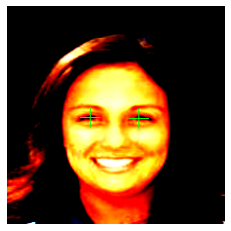

In [ ]:
sample_number = 16
image = train_dataset[sample_number][0]
image = image.permute(1,2,0).detach().numpy()
image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
Gender = 'male' if int(train_dataset[sample_number][1][0])==1 else 'female'
print('Gender is: ', Gender)
w, h = train_dataset[sample_number][1][2]
(x1, y1) = train_dataset[sample_number][1][1][0:2]
(x2, y2) = train_dataset[sample_number][1][1][2:4]
x1, x2 = int(x1*h), int(x2*h)
y1, y2 = int(y1*w), int(y2*w)
image_rgb	=	cv2.drawMarker(image_rgb, (x1,y1), (0,255,0))
image_rgb	=	cv2.drawMarker(image_rgb, (x2,y2), (0,255,0))
image_rgb = np.clip(image_rgb , 0, 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## Network

Below, we define a new class, named 'ClassifierLocalizer, which accepts a pre-trained CNN and changes its last fully connected layer to be proper for the two task problem. The new fully connected layer contains 6 neurons, 2 for the classification task (male or female) and 4 for the localization task (x and y for the left and right eyes). Moreover, to put the location results on the same scale as the class scores, we apply the sigmoid function to the neurons assigned for the localization task.

In [ ]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes
        
        # create cnn model
        model = models.__dict__[model_name](True)
        
        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 6) # classifier + localizer
        self.model = model
    
    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # coordinates
        return [scores, F.sigmoid(coords)[:]]     # sigmoid output is in [0, 1]

Regarding the complexity of the problem, the number of the samples in the training dataset, and the similarity of the training dataset to the ImageNet dataset, we may decide to freeze some of the layers. In our current example, based on the mentioned factors, we freeze just the last fully connected layer.

In [ ]:
network = ClassifierLocalizer(model_name='resnet18')

def freeze_weights(network):
    for name, param in network.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(network)
network

ClassifierLocalizer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
save_path = './callbacks'
os.makedirs(save_path, exist_ok=True)
callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}.ckpt'), monitor='val_loss', mode='min',
                    save_best_only=True, restore_best=True, verbose=True),

    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

## Loss function

As we discussed before, we have two different tasks in this example. These tasks need different loss functions; Cross-Entropy loss for the classification and Mean Square Error loss for the regression. Below, we define a new loss function class that sums both losses to considers them simultaneously. However, as the regression is relatively a harder task, we apply a higher weight to MSEloss.

In [ ]:
class classification_regression_Loss(nn.Module):
    def __init__(self):
        super(classification_regression_Loss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss() # size_average=False
        self.mse_loss = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        # Cross Entropy Error (for classification)
        loss_cls = self.ce_loss(y_pred[0], y_true[0]) 
        # Mean Squared Error (for landmarks)
        loss_reg = self.mse_loss(y_pred[1], y_true[ 1])
        total_loss = loss_reg + loss_cls
        return total_loss

## Training

In [ ]:
optimizer = optim.Adagrad(network.parameters(), lr=0.0001, weight_decay=0)
loss_function = classification_regression_Loss()
#SL =StepLR(step_size=2 , gamma=0.1, last_epoch=-1, verbose=False)
exp1 = Experiment('./two_task_example', network, optimizer=optimizer, loss_function=loss_function, device="all")
exp1.train(train_dataloader, valid_dataloader, callbacks=callbacks, epochs=28) #lr_schedulers=SL

Epoch:  1/28 Step:  1/10  10.00% |██                  |ETA: 34.14s loss: 0.838301

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  1/28 Train steps: 10 Val steps: 4 45.32s loss: 0.946098 val_loss: 1.020222
Epoch 1: val_loss improved from inf to 1.02022, saving file to ./two_task_example/checkpoint_epoch_1.ckpt
Epoch 1: val_loss improved from inf to 1.02022, saving file to ./callbacks/best_epoch_1.ckpt
Epoch:  2/28 Train steps: 10 Val steps: 4 44.93s loss: 0.942724 val_loss: 0.994162
Epoch 2: val_loss improved from 1.02022 to 0.99416, saving file to ./two_task_example/checkpoint_epoch_2.ckpt
Epoch 2: val_loss improved from 1.02022 to 0.99416, saving file to ./callbacks/best_epoch_2.ckpt
Epoch:  3/28 Train steps: 10 Val steps: 4 45.88s loss: 0.953241 val_loss: 0.992527
Epoch 3: val_loss improved from 0.99416 to 0.99253, saving file to ./two_task_example/checkpoint_epoch_3.ckpt
Epoch 3: val_loss improved from 0.99416 to 0.99253, saving file to ./callbacks/best_epoch_3.ckpt
Epoch:  4/28 Train steps: 10 Val steps: 4 45.19s loss: 0.942391 val_loss: 0.993987
Epoch:  5/28 Train steps: 10 Val steps: 4 44.89s loss: 

[{'epoch': 1,
  'loss': 0.9460984490388213,
  'time': 45.31904164000002,
  'val_loss': 1.0202224362980237},
 {'epoch': 2,
  'loss': 0.9427235285972672,
  'time': 44.93315522299997,
  'val_loss': 0.994161950217353},
 {'epoch': 3,
  'loss': 0.953240783517576,
  'time': 45.88221875900001,
  'val_loss': 0.9925269213589755},
 {'epoch': 4,
  'loss': 0.9423910678429747,
  'time': 45.192564403000006,
  'val_loss': 0.9939865211043695},
 {'epoch': 5,
  'loss': 0.9474611896336278,
  'time': 44.89197103499998,
  'val_loss': 0.9955827407162599},
 {'epoch': 6,
  'loss': 0.9534642419288788,
  'time': 44.876600936000045,
  'val_loss': 0.9887565449632779},
 {'epoch': 7,
  'loss': 0.9475283032675651,
  'time': 45.041467245000035,
  'val_loss': 0.9949218167199029},
 {'epoch': 8,
  'loss': 0.9423452013711068,
  'time': 45.225190913999995,
  'val_loss': 0.9969907035731306},
 {'epoch': 9,
  'loss': 0.9393246514741393,
  'time': 45.250883708999936,
  'val_loss': 1.0035923562868676},
 {'epoch': 10,
  'loss': 

## Evaluation

In [ ]:
model = Model(network, optimizer, loss_function, device=device)
loss, predictions, Ground_Truth = model.evaluate_generator(valid_dataloader, callbacks=callbacks, return_pred=True, return_ground_truth=True)

Step: 1/4  25.00% |█████               |ETA: 10.46s test_loss: 0.957756

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test steps: 4 10.73s test_loss: 0.982822                              


In [ ]:
import pandas as pd
logs = pd.read_csv('./callbacks/log.tsv', sep='\t')
logs

,epoch,time,lr,loss,val_loss
0,1,45.319042,0.0001,0.946098,1.020222
1,2,44.933155,0.0001,0.942724,0.994162
2,3,45.882219,0.0001,0.953241,0.992527
3,4,45.192564,0.0001,0.942391,0.993987
4,5,44.891971,0.0001,0.947461,0.995583
5,6,44.876601,0.0001,0.953464,0.988757
6,7,45.041467,0.0001,0.947528,0.994922
7,8,45.225191,0.0001,0.942345,0.996991
8,9,45.250884,0.0001,0.939325,1.003592
9,10,44.447658,0.0001,0.941813,0.998188


In [ ]:
exp1.test(valid_dataloader)

Found best checkpoint at epoch: 15
lr: 0.0001, loss: 0.956844, val_loss: 0.982822
Loading checkpoint ./two_task_example/checkpoint_epoch_15.ckpt
Running test
Step: 1/4  25.00% |█████               |ETA: 10.33s test_loss: 1.059451

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test steps: 4 10.57s test_loss: 0.982822                              


{'test_loss': 0.98282164515871, 'time': 10.572555282999929}

Gender is:  male


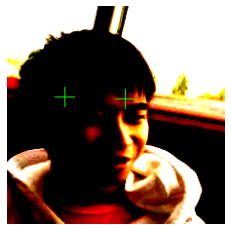

In [ ]:
sample_number = 10
image = valid_dataset[sample_number][0]
image = image.permute(1,2,0).detach().numpy()
image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
Gender = 'male' if np.where(predictions[0][sample_number]==max(predictions[0][sample_number]))[0]==0 else 'female'
print('Gender is: ', Gender)
w, h = valid_dataset[sample_number][1][2]
(x1, y1) = predictions[1][sample_number][0:2]
(x2, y2) = predictions[1][sample_number][2:4]
x1, x2 = int(x1*h), int(x2*h)
y1, y2 = int(y1*w), int(y2*w)
image_rgb	=	cv2.drawMarker(image_rgb, (x1,y1), (0,255,0))
image_rgb	=	cv2.drawMarker(image_rgb, (x2,y2), (0,255,0))
image_rgb = np.clip(image_rgb , 0, 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()